# Best Model Script

This script uploads the current best model to the S3 bucket.

In [1]:
import boto3
import datetime
import os
import pandas as pd
import pprint
import psycopg2
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tempfile

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
aws_psql_conn = psycopg2.connect(
    database=os.getenv("AWS_PSQL_DB"),
    user=os.getenv("AWS_PSQL_USER"),
    password=os.getenv("AWS_PSQL_PASSWORD"),
    host=os.getenv("AWS_PSQL_HOST"),
    port=os.getenv("AWS_PSQL_PORT"),
)

cursor = aws_psql_conn.cursor()

In [3]:
sql = f"select * from games"

cursor.execute(sql)

rows = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

In [4]:
df = pd.DataFrame(rows, columns=column_names)

df.head()

,game_id,home_team_id,home_team_name,away_team_id,away_team_name,home_pitcher,home_pitcher_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,...,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip,predicted_winner
0,718698,158,Milwaukee Brewers,121,New York Mets,Corbin Burnes,669203.0,7.2,0.0,0.0,...,5.4,0.0,1.4,0.25,9.0,1.8,0.181818,1.8,0.466667,1.0
1,718781,147,New York Yankees,137,San Francisco Giants,Gerrit Cole,543037.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,718782,111,Boston Red Sox,110,Baltimore Orioles,Corey Kluber,446372.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,718777,112,Chicago Cubs,158,Milwaukee Brewers,Marcus Stroman,573186.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,718776,139,Tampa Bay Rays,116,Detroit Tigers,Shane McClanahan,663556.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
columns_to_remove = [
    "home_team_name",
    "away_team_name",
    "home_pitcher",
    "home_pitcher_id",
    "away_pitcher",
    "away_pitcher_id",
    "predicted_winner"
]

df = df.drop(columns=columns_to_remove)

df.head()

,game_id,home_team_id,away_team_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,home_pitcher_losses,home_pitcher_innings_pitched,away_pitcher_era,away_pitcher_win_percentage,...,home_pitcher_k_nine,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip
0,718698,158,121,7.2,0.0,0.0,1.0,5.0,1.8,0.0,...,5.4,5.4,0.0,1.4,0.25,9.0,1.8,0.181818,1.8,0.466667
1,718781,147,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,718782,111,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,718777,112,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,718776,139,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df.dropna()

df.head()

,game_id,home_team_id,away_team_id,home_pitcher_era,home_pitcher_win_percentage,home_pitcher_wins,home_pitcher_losses,home_pitcher_innings_pitched,away_pitcher_era,away_pitcher_win_percentage,...,home_pitcher_k_nine,home_pitcher_bb_nine,home_pitcher_k_bb_diff,home_pitcher_whip,home_pitcher_babip,away_pitcher_k_nine,away_pitcher_bb_nine,away_pitcher_k_bb_diff,away_pitcher_whip,away_pitcher_babip
0,718698,158,121,7.20,0.000,0.0,1.0,5.0,1.8,0.0,...,5.40,5.40,0.000000,1.40,0.250000,9.0,1.80,0.181818,1.80,0.466667
72,718703,119,115,3.00,1.000,1.0,0.0,6.0,3.0,1.0,...,9.00,0.00,0.285714,0.67,0.285714,7.5,0.00,0.208333,0.83,0.294118
73,718704,120,139,6.00,0.000,0.0,1.0,3.0,0.0,1.0,...,9.00,9.00,0.000000,3.33,0.500000,9.0,1.50,0.227273,0.83,0.266667
74,718701,146,142,0.00,1.000,1.0,0.0,5.6,0.0,1.0,...,7.94,6.35,0.047619,1.06,0.166667,13.5,5.06,0.238095,0.94,0.222222
77,717821,116,109,5.23,0.429,3.0,4.0,53.3,5.4,0.4,...,8.94,3.71,0.134199,1.33,0.285714,5.4,3.21,0.056391,1.49,0.314721


In [7]:
df.columns

Index(['game_id', 'home_team_id', 'away_team_id', 'home_pitcher_era',
       'home_pitcher_win_percentage', 'home_pitcher_wins',
       'home_pitcher_losses', 'home_pitcher_innings_pitched',
       'away_pitcher_era', 'away_pitcher_win_percentage', 'away_pitcher_wins',
       'away_pitcher_losses', 'away_pitcher_innings_pitched', 'winning_team',
       'home_pitcher_k_nine', 'home_pitcher_bb_nine', 'home_pitcher_k_bb_diff',
       'home_pitcher_whip', 'home_pitcher_babip', 'away_pitcher_k_nine',
       'away_pitcher_bb_nine', 'away_pitcher_k_bb_diff', 'away_pitcher_whip',
       'away_pitcher_babip'],
      dtype='object')

In [8]:
X = []
Y = []

for index, row in df.iterrows():
    print(index, row)
    pitcher_innings_pitched_comp = row['away_pitcher_innings_pitched'] - row['home_pitcher_innings_pitched']
    pitcher_k_nine_comp = row['away_pitcher_k_nine'] - row['home_pitcher_k_nine']
    pitcher_bb_nine_comp = row['away_pitcher_bb_nine'] - row['home_pitcher_bb_nine']
    pitcher_k_bb_diff_comp = row['away_pitcher_k_bb_diff'] - row['home_pitcher_k_bb_diff']
    pitcher_whip_comp = row['away_pitcher_whip'] - row['home_pitcher_whip']
    pitcher_babip_comp = row['away_pitcher_babip'] - row['home_pitcher_babip']

    comparison = [pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp]

    X.append(comparison)
    Y.append(1 if row['winning_team'] == row['home_team_id'] else 0)


0 game_id                         718698.000000
home_team_id                       158.000000
away_team_id                       121.000000
home_pitcher_era                     7.200000
home_pitcher_win_percentage          0.000000
home_pitcher_wins                    0.000000
home_pitcher_losses                  1.000000
home_pitcher_innings_pitched         5.000000
away_pitcher_era                     1.800000
away_pitcher_win_percentage          0.000000
away_pitcher_wins                    0.000000
away_pitcher_losses                  1.000000
away_pitcher_innings_pitched         5.000000
winning_team                       158.000000
home_pitcher_k_nine                  5.400000
home_pitcher_bb_nine                 5.400000
home_pitcher_k_bb_diff               0.000000
home_pitcher_whip                    1.400000
home_pitcher_babip                   0.250000
away_pitcher_k_nine                  9.000000
away_pitcher_bb_nine                 1.800000
away_pitcher_k_bb_diff          

In [9]:
# Convert the lists to NumPy arrays for compatibility with scikit-learn
X = pd.np.array(X)
Y = pd.np.array(Y)
X = X.reshape(X.shape[0], -1)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1112, 6)
X_test shape: (279, 6)
Y_train shape: (1112,)
Y_test shape: (279,)


In [11]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [12]:
# Make predictions on the training set (you can use a separate test set for predictions)
print(X_test)
pred = model.predict(X_test)

zeroes = 0
ones = 0

for item in pred:
    if item == 0:
        zeroes += 1
    elif item == 1:
        ones += 1

print(zeroes, ones)


[[ 2.70000000e+00 -2.64000000e+00  5.30000000e-01 -9.21676779e-02
   2.30000000e-01  4.35914635e-02]
 [ 8.60000000e+00 -4.63000000e+00 -2.35000000e+00 -5.71342942e-02
  -1.10000000e-01 -5.72285636e-02]
 [-3.00000000e+01 -4.30000000e-01 -7.80000000e-01  7.79715947e-03
  -3.00000000e-02  1.39736907e-02]
 ...
 [ 5.50000000e+01  9.10000000e-01 -7.30000000e-01  4.57972973e-02
  -3.90000000e-01 -6.28259551e-02]
 [-1.30000000e+01 -1.85000000e+00 -2.34000000e+00  1.25307125e-02
  -1.00000000e-02  1.72764228e-02]
 [ 1.70000000e+00 -4.10000000e-01  8.70000000e-01 -2.83653846e-02
  -7.00000000e-02 -3.93203883e-02]]
85 194


In [13]:
# Evaluate the model's performance (e.g., accuracy, precision, recall)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5555555555555556


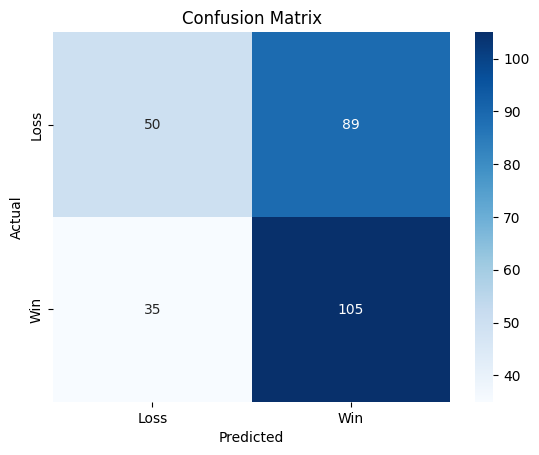

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(Y_test, pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Loss', 'Win'])
plt.plot(1, 1)
plt.yticks([0.5, 1.5], ['Loss', 'Win'])

# Display the plot
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
classification_rep = classification_report(Y_test, pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.59      0.36      0.45       139
           1       0.54      0.75      0.63       140

    accuracy                           0.56       279
   macro avg       0.56      0.55      0.54       279
weighted avg       0.56      0.56      0.54       279



In [16]:
now = datetime.datetime.now()

model_object = (model, {"date created": now, "model type": "Logistic Regression", "parameters used": "pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp", "accuracy": accuracy, "training set size": Y_train.shape[0], "testing set size": Y_test.shape[0]})

pprint.pprint(model_object)

(LogisticRegression(),
 {'accuracy': 0.5555555555555556,
  'date created': datetime.datetime(2023, 9, 6, 20, 34, 19, 663032),
  'model type': 'Logistic Regression',
  'parameters used': 'pitcher_innings_pitched_comp, pitcher_k_nine_comp, '
                     'pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, '
                     'pitcher_whip_comp, pitcher_babip_comp',
  'testing set size': 279,
  'training set size': 1112})


In [17]:
current_time = str(now).replace(" ", "_")[:19].replace(":", "-")

temp = tempfile.NamedTemporaryFile(prefix=current_time, suffix="_temp", mode="w")

In [18]:
with open(temp.name,"wb") as f:
    pickle.dump(model_object, f)

In [19]:
client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("SECRET_ACCESS_KEY"),
)

In [20]:

s3 = boto3.resource("s3")
key = f"{current_time}-model.pickle"
s3.meta.client.upload_file(
    Filename=temp.name,
    Bucket=os.getenv("AWS_S3_MODEL_SRC"),
    Key=key,
)

print(f"File uploaded to bucket {os.getenv('AWS_S3_MODEL_SRC')} as {key}")

File uploaded to bucket mlb-prediction-model as 2023-09-06_20-34-19-model.pickle
